6.0


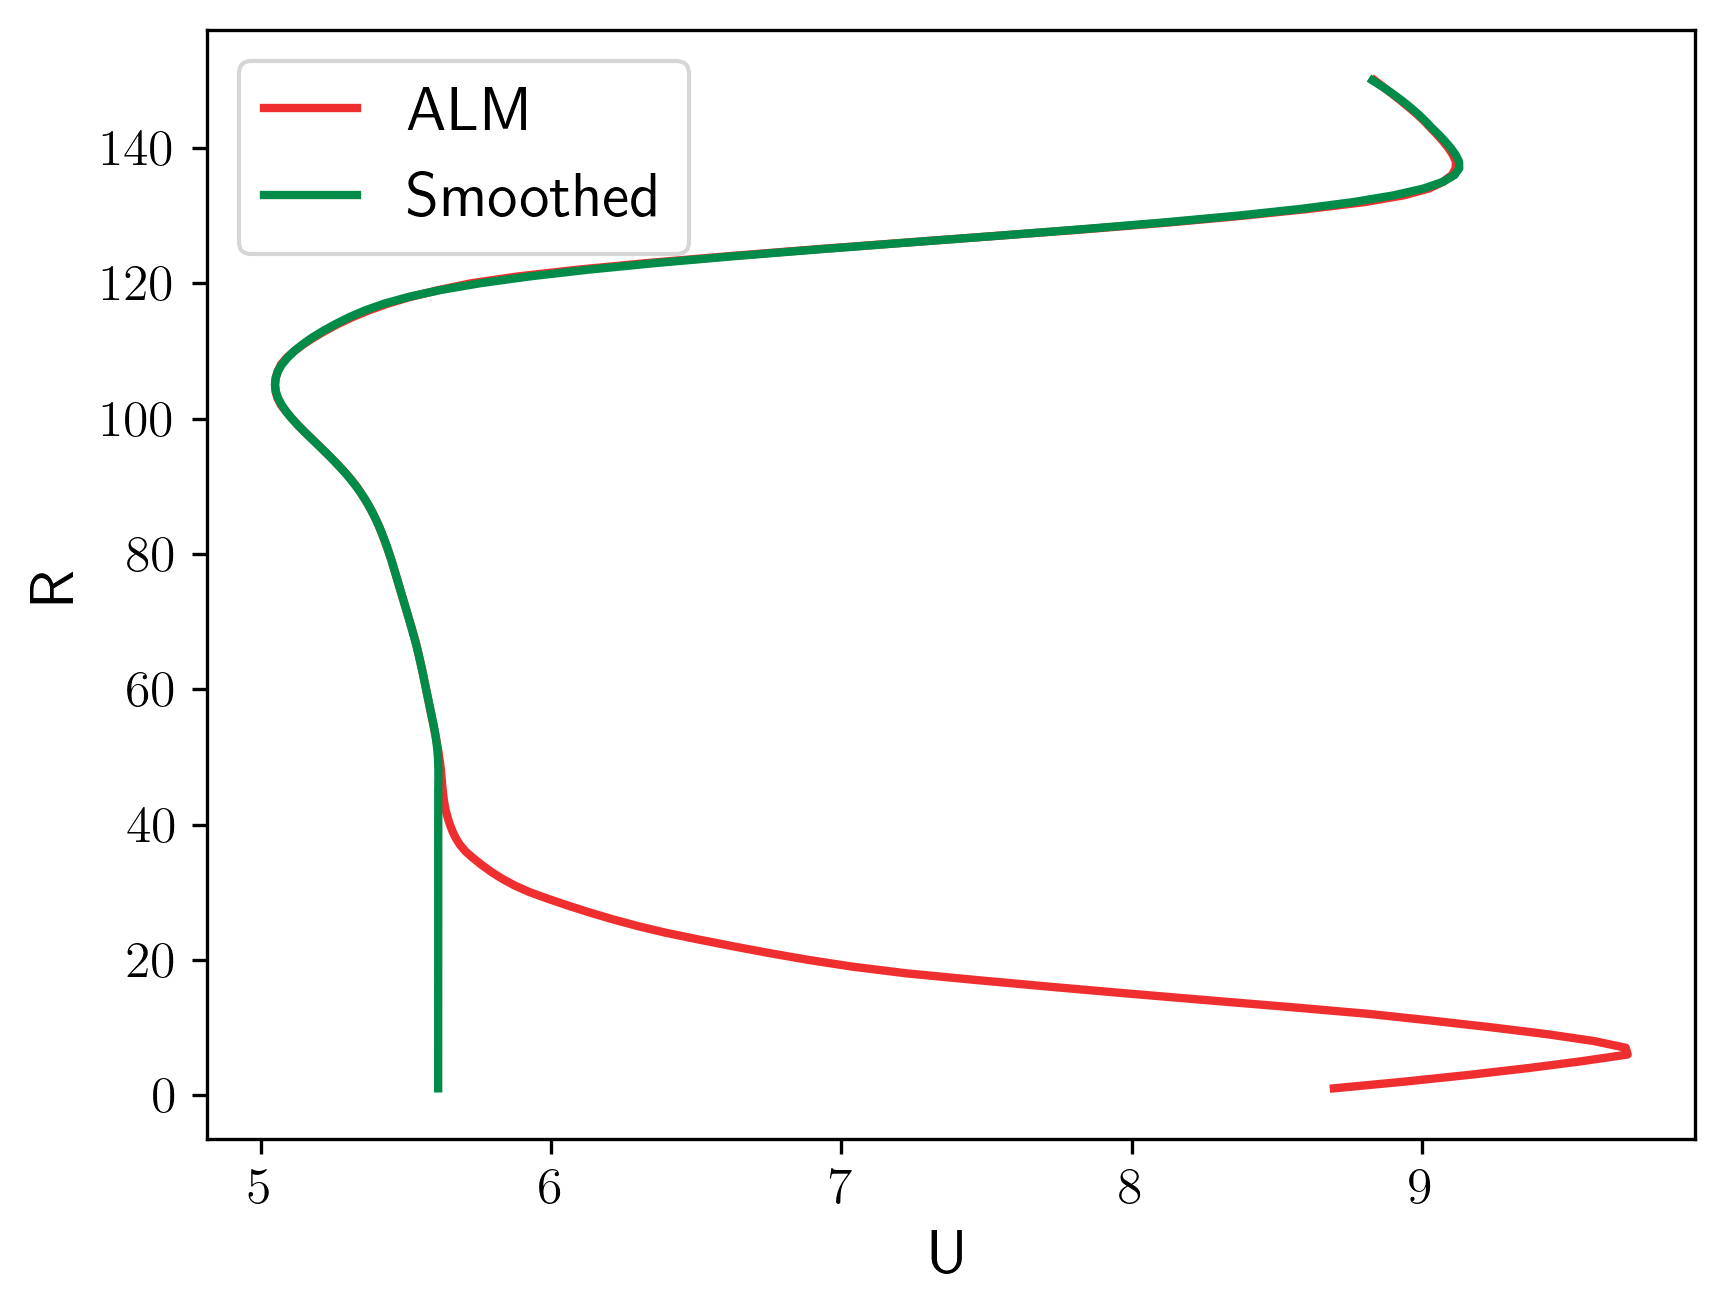

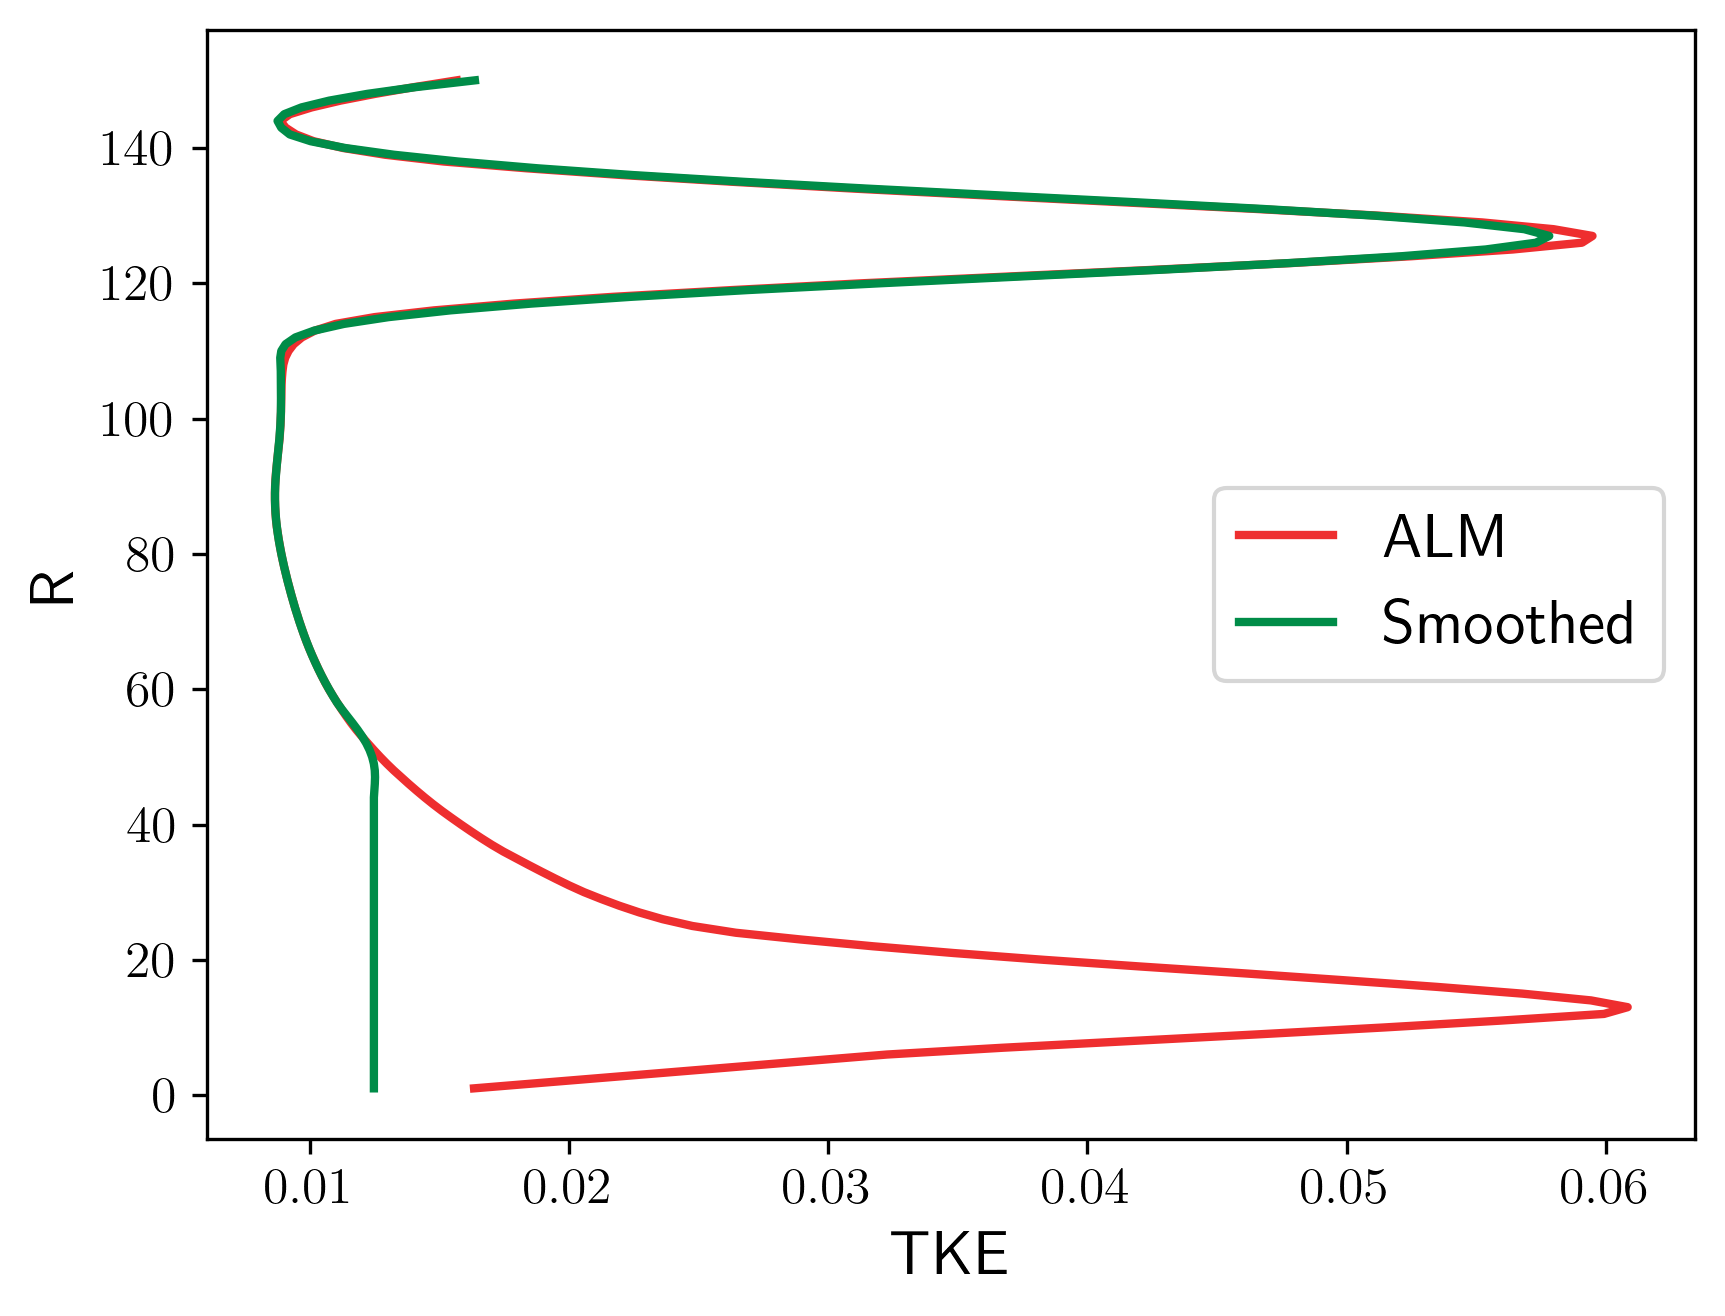

In [49]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

import SANDLST
import SANDRANS


def tanhUprofile(r, U0, U1, rdelta, delta):
    return 0.5 * (U1 - U0) * (1.0 + np.tanh((r - rdelta) / delta)) + U0

# Set RANS parameters
params = {
    "Re": 1.0 / 1.47e-5,
    "C_mu": 5.48 ** (-2),
    "C_1e": 1.176,
    "C_2e": 1.92,
    "sigma_k": 1.0,
    "sigma_e": 1.3,
    "laminar": False,
}

# Read profile data from postprocessed data
dpath = "/Users/pmohan/flowmas/SANDwake/RANSCalibration/Data"
rp = "MedWSLowTI"
vfile = f"{dpath}/{rp}_YZwake1_rprofile_0.csv"
vdata = np.loadtxt(vfile,skiprows=1,delimiter=',')
num_rows = len(vdata)
N = num_rows
U = vdata[:N,1]
def smooth(v, iclip = 50):
    v_mod = v.copy()
    v_mod[:iclip] = v_mod[iclip]
    return savgol_filter(v_mod, 15, 2)
U_smooth = smooth(U)
k = vdata[:N,4]
k_smooth = smooth(k)
# Set the radial grid
rvec = vdata[:N,0]
print(rvec[np.argmax(U)])

plt.figure()
plt.plot(U, rvec, label = "ALM")
plt.plot(U_smooth, rvec, label = "Smoothed")
plt.xlabel('U')
plt.ylabel('R')
plt.legend()
plt.figure()
plt.plot(k, rvec, label = "ALM")
plt.plot(k_smooth, rvec, label = "Smoothed")
plt.xlabel('TKE')
plt.ylabel('R')
plt.legend()
#plt.plot(tanhUprofile(rvec, U[50],np.max(U), 130, 8), rvec)

In [53]:
# Set the radial grid
dx = 10
Nsteps = 500

# Setup initial conditions
Uinit = U_smooth.copy()
kinit = k_smooth.copy()
U0 = np.min(Uinit)
Uinf = np.max(Uinit)
Vinit = np.zeros(N)
einit = SANDRANS.set_e_init(rvec, dr, Uinit, kinit, params)
phi_init = {"u": Uinit, "v": Vinit, "k": kinit, "e": einit}

# Setup boundary conditions
UBC = [
    {"type": "neumann", "value": 0.0},  # Lower
    {"type": "dirichlet", "value": Uinf},  # Upper
]
VBC = [
    {"type": "dirichlet", "value": 0.0},  # Lower
    None,  # Upper (This is hard-coded)
]
kBC = [
    {"type": "neumann", "value": 0.0},  # Lower
    {"type": "dirichlet", "value": 0.0},  # Upper
]
eBC = [
    {"type": "neumann", "value": 0.0},  # Lower
    {"type": "dirichlet", "value": 0.0},  # Upper
]
BCdict = {"u": UBC, "v": VBC, "k": kBC, "e": eBC}

# No modes for calibration
moderegistryNOFCS = []

# Compute the wake using RANS
uarrayNOFCS, varrayNOFCS, karrayNOFCS, earrayNOFCS, xvec = SANDRANS.marchWakeBL(
    phi_init,
    Nsteps,
    rvec,
    params,
    BCdict,
    dx_init=dx,
    moderegistry=moderegistryNOFCS,
    LSTNr=1001,
    calcFCS=False,
    verbose=False,
)
print(xvec)

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0, 600.0, 610.0, 620.0, 630.0, 640.0, 650.0, 660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720.0, 730.0, 740.0, 750.0, 760.0, 770.0, 780.0, 790.0, 800.0, 810.0, 820.0, 830.0, 840.0, 850.0, 860.0, 870.0, 880.0, 890.0, 900.0, 910.0, 920.0, 930.0, 940.0, 950.0, 960.0, 970.0, 980.0, 990.0, 1000.0, 1010.0, 1020.0, 1030.0, 1040.0, 1050.0, 1060.0, 1070.0, 1080.0, 1090.0, 1100.0, 1110.0, 1120.0, 1130.0, 1140.0, 1150.0, 1160.0, 1170.0, 1180.0, 1190.0, 1200.0, 1210.0, 1220.0, 1230.0, 1240.0, 1250.0, 1260.0, 1270.0, 1280.0, 1290.0, 1300.0, 1310.0, 1320.0, 1330.0, 1340.0, 1350.0, 1360.0, 1370.0, 1380.0

[0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1050.0, 1100.0, 1150.0, 1200.0, 1250.0, 1300.0, 1350.0, 1400.0, 1450.0, 1500.0, 1550.0, 1600.0, 1650.0, 1700.0, 1750.0, 1800.0, 1850.0, 1900.0, 1950.0, 2000.0, 2050.0, 2100.0, 2150.0, 2200.0, 2250.0, 2300.0, 2350.0, 2400.0, 2450.0, 2500.0, 2550.0, 2600.0, 2650.0, 2700.0, 2750.0, 2800.0, 2850.0, 2900.0, 2950.0, 3000.0, 3050.0, 3100.0, 3150.0, 3200.0, 3250.0, 3300.0, 3350.0, 3400.0, 3450.0, 3500.0, 3550.0, 3600.0, 3650.0, 3700.0, 3750.0, 3800.0, 3850.0, 3900.0, 3950.0, 4000.0, 4050.0, 4100.0, 4150.0, 4200.0, 4250.0, 4300.0, 4350.0, 4400.0, 4450.0, 4500.0, 4550.0, 4600.0, 4650.0, 4700.0, 4750.0, 4800.0, 4850.0, 4900.0, 4950.0, 5000.0]
(501, 150)


Text(0, 0.5, 'Momentum Thickness')

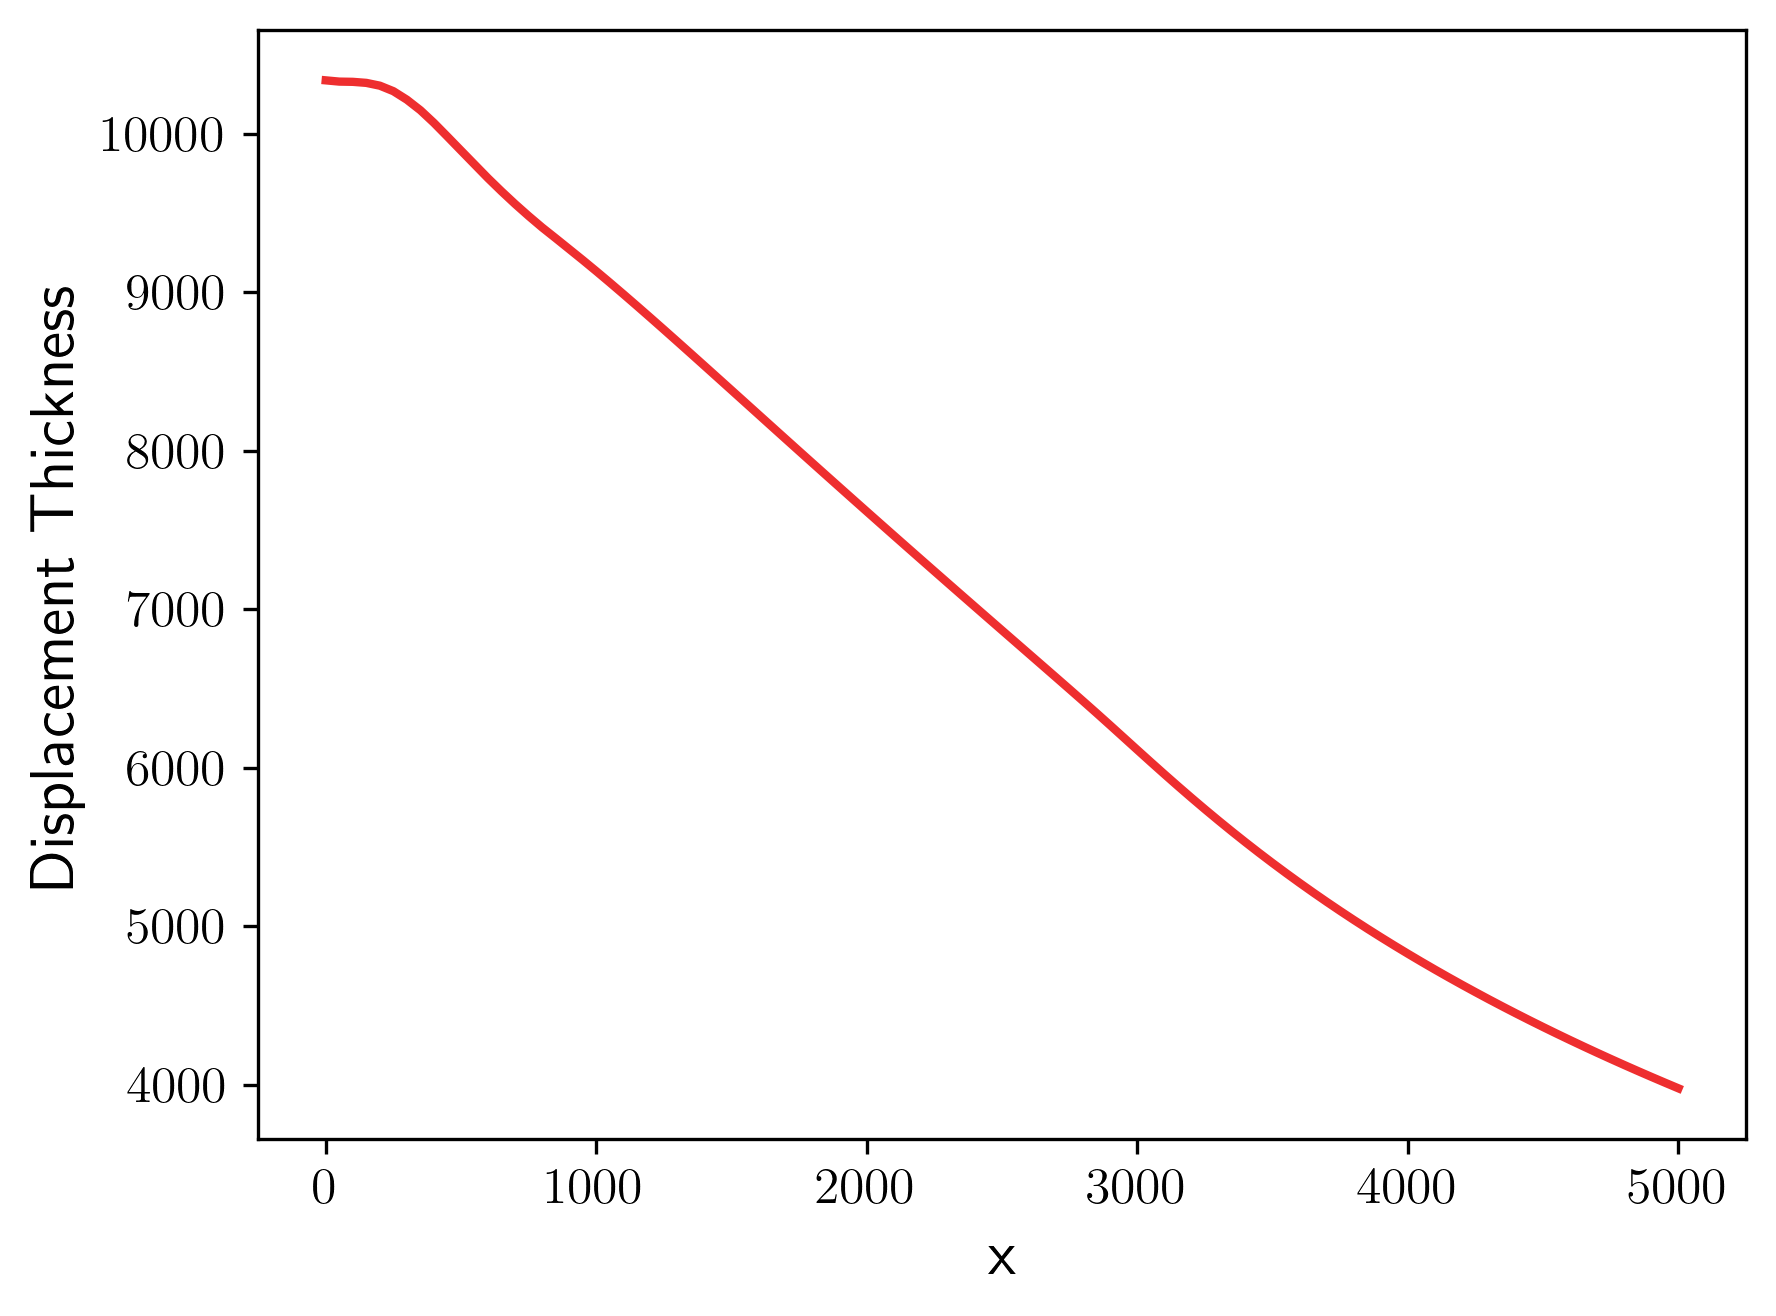

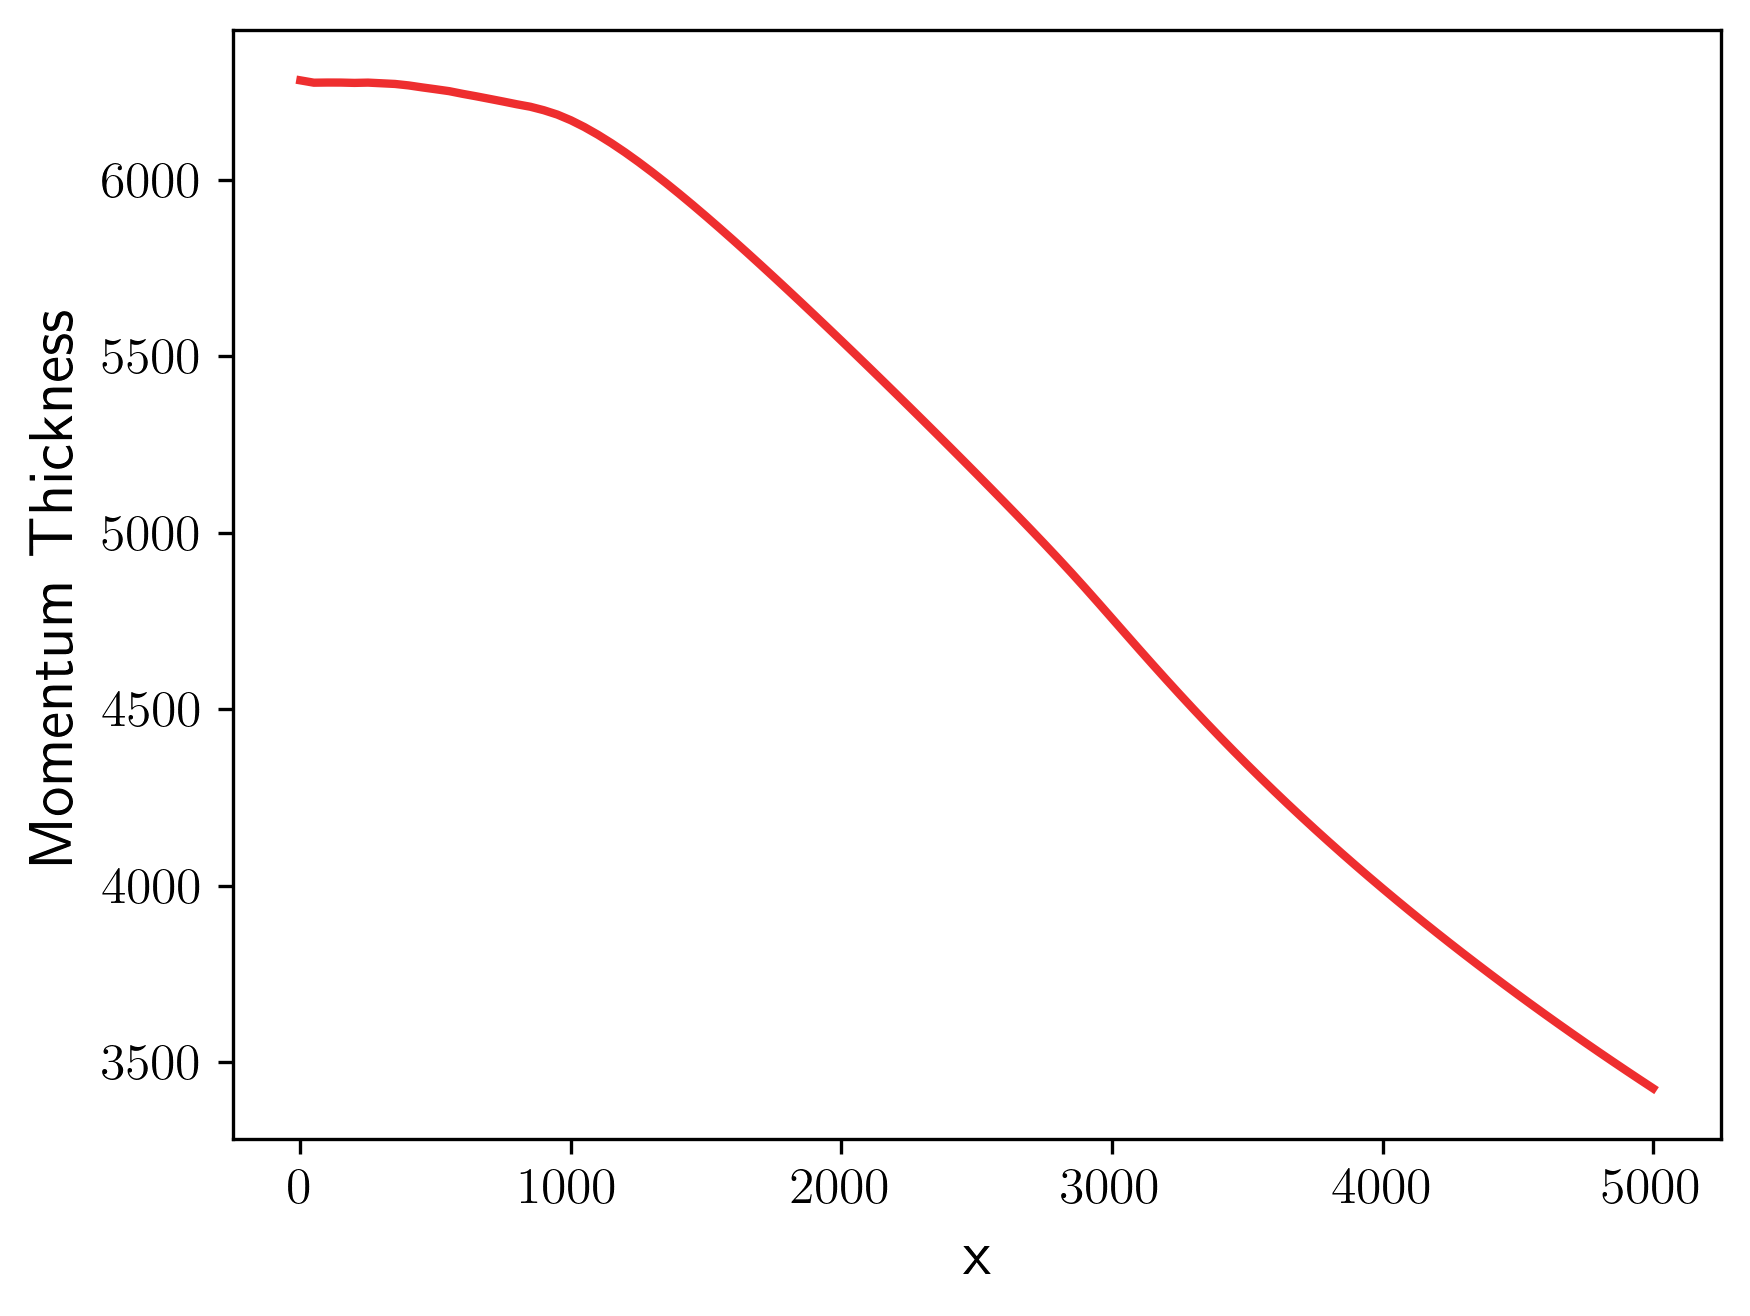

In [61]:
# Gather calibration outputs, currently wake thickness, centerline velocity
x_outputs = xvec[::5]
wake_stats = np.empty((len(x_outputs), 4))
for ix, x in enumerate(x_outputs):
    wake_stats[ix, 0] = x
    idx = np.searchsorted(xvec, x)
    wake_stats[ix, 1] = SANDLST.calcDeltaThick(uarrayNOFCS[idx, :], Uinf, rvec) # wake displacement
    wake_stats[ix, 2] = SANDLST.calcDeltaMom(uarrayNOFCS[idx, :], Uinf, rvec) # wake momentum thickness
    wake_stats[ix, 3] = np.min(uarrayNOFCS[idx, :]) # center line velocity
# Plots
plt.figure()
plt.plot(x_outputs, wake_stats[:,1]*np.pi)
plt.xlabel('x')
plt.ylabel('Displacement Thickness')
plt.figure()
plt.plot(x_outputs, wake_stats[:,2]*np.pi)
plt.xlabel('x')
plt.ylabel('Momentum Thickness')